# MUDAB2G1 - Grupo 3 - TFM: Modelo de predicción de precios de acciones

Este notebook pertenece al Grupo 3 del MUDAB2G1. Cuyos miembros de equipo son:

* Carrillo Ng, Sebastián Elías
* Cifuentes Guzmán, Yaros Josué
* Donoso Muñoz, Javier Esteban

## Objetivo del notebook: Modelo de clasificación de acciones bursátiles
El propósito de este notebook es desarrollar un modelo de clasificación que prediga la dirección del precio de una acción (sube o baja) integrando tanto variables financieras estructuradas como información cualitativa extraída de noticias mediante análisis de sentimiento y embeddings de lenguaje (FinBERT).

Se explorarán diferentes conjuntos de features, modelos base y técnicas de ensamblado. Además, se aplicará ajuste de hiperparámetros y estrategias de validación para optimizar el rendimiento predictivo del modelo.

## Preparación del entorno
En este apartado descargamos e importamos todas las librerías necesarias para el desarrollo del proyecto así como preparamos los datos para poder realizar los análisis posteriores.

### Librerías

In [ ]:
import os
import time
import random
import warnings
import datetime
import itertools
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

import librosa
import torchaudio
import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import optuna
from optuna.integration.tfkeras import TFKerasPruningCallback

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

2025-06-28 10:34:33.158276: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-28 10:34:33.170245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751106873.184806   31284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751106873.189166   31284 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751106873.199940   31284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Datasets

En esta sección parametrizamos datos que utilizaremos reiteradamente, como las fechas para separar nuestros conjuntos de Train/Test/Validation.

Por otro lado, en esta sección añadimos todos los dataframes necesarios para crear nuestra data final. Esto incluye datos financieros de la acción, análisis de sentimiento y datos macroeconómicos.

In [ ]:
# Creación y Lectura de DataFrames

# Stock Data
stock_data = pd.read_csv("tesla_stock.csv", parse_dates=['date'])
stock_data['ema5'] = stock_data['close'].ewm(span=5, adjust=False).mean()
stock_data['ema20'] = stock_data['close'].ewm(span=20, adjust=False).mean()
stock_data['log_return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))
stock_data_columns = stock_data.columns.drop('date')

# Finbert Sentiment Data
finbert_sentiment_data = pd.read_csv("tesla_sentiment.csv")
finbert_sentiment_data['date'] = pd.to_datetime(finbert_sentiment_data['publish_date'])
finbert_sentiment_data = finbert_sentiment_data[['date','finbert_final_sentiment']]

# Finbert Embbedings Data
finbert_embedding_data = pd.read_csv("tesla_sentiment.csv")
finbert_embedding_data['date'] = pd.to_datetime(finbert_embedding_data['publish_date'])
finbert_embedding_data = finbert_embedding_data.drop(columns=['publish_date','finbert_final_sentiment'])
embeddings_columns = finbert_embedding_data.columns.drop('date')

# Macroeconomic Data
macroeconomic_variables = pd.read_csv("macroeconomic_variables.csv")
macroeconomic_variables['date'] = pd.to_datetime(macroeconomic_variables['date'])

# Merged Data
start_date = '2019-01-01'
end_date = '2024-12-31'
base_df = pd.DataFrame({'date': stock_data['date'].sort_values()})
base_df = base_df[(base_df['date'] >= start_date) & (base_df['date'] <= end_date)]
merged_df = pd.merge(base_df, stock_data, on='date', how='left')
merged_df = pd.merge(merged_df, finbert_sentiment_data, on='date', how='left')
merged_df = pd.merge(merged_df, finbert_embedding_data, on='date', how='left')
merged_df = pd.merge(merged_df, macroeconomic_variables, on='date', how='left')
merged_df.set_index("date", inplace=True)
# merged_df = merged_df.fillna(0)
merged_df = merged_df.fillna(method='ffill')
# Crear variable objetivo binaria: 1 si el precio sube, 0 si baja o se mantiene
merged_df['label_price'] = (merged_df['close'].shift(-1) > merged_df['close']).astype(int)

# Eliminar la última fila (sin valor para el día siguiente)
merged_df = merged_df.iloc[:-1]

### Feature engineering
Como parte de los pasos previos al modelado, se lleva a cabo un proceso de feature engineering para enriquecer el conjunto de datos con variables adicionales que capturen patrones temporales, de mercado y macroeconómicos. Esto incluye la creación de variables lagueadas (históricas), indicadores técnicos derivados de precios y volumen, así como el cálculo de features macroeconómicas compuestas como el índice de condiciones financieras, apetito por riesgo y riesgo de recesión. Estas variables buscan proporcionar al modelo una mayor capacidad de representación y mejorar su rendimiento predictivo.

In [ ]:
# Listado de variables a las que se aplicarán lags, dado que los efectos de una noticia podrían no manifestarse de forma inmediata, sino con un cierto lag.
variables_a_laguear = ['return_1d', 'volume', 'vix', 'finbert_final_sentiment']

# Crear una copia para no modificar directamente merged_df, en caso de que se desee preservar el conjunto de datos original.
df = merged_df.copy()

# Generar lags
for var in variables_a_laguear:
    for lag in range(1, 31):
        df[f"{var}_lag{lag}"] = df[var].shift(lag)

# Eliminar filas con NaNs
df = df.dropna().reset_index(drop=True)

# Ver columnas de lags generadas
print("✅ Columnas con lags creadas:")
print([col for col in df.columns if any(v in col for v in variables_a_laguear) and "lag" in col])

✅ Columnas con lags creadas:
['return_1d_lag1', 'return_1d_lag2', 'return_1d_lag3', 'return_1d_lag4', 'return_1d_lag5', 'return_1d_lag6', 'return_1d_lag7', 'return_1d_lag8', 'return_1d_lag9', 'return_1d_lag10', 'return_1d_lag11', 'return_1d_lag12', 'return_1d_lag13', 'return_1d_lag14', 'return_1d_lag15', 'return_1d_lag16', 'return_1d_lag17', 'return_1d_lag18', 'return_1d_lag19', 'return_1d_lag20', 'return_1d_lag21', 'return_1d_lag22', 'return_1d_lag23', 'return_1d_lag24', 'return_1d_lag25', 'return_1d_lag26', 'return_1d_lag27', 'return_1d_lag28', 'return_1d_lag29', 'return_1d_lag30', 'volume_lag1', 'volume_lag2', 'volume_lag3', 'volume_lag4', 'volume_lag5', 'volume_lag6', 'volume_lag7', 'volume_lag8', 'volume_lag9', 'volume_lag10', 'volume_lag11', 'volume_lag12', 'volume_lag13', 'volume_lag14', 'volume_lag15', 'volume_lag16', 'volume_lag17', 'volume_lag18', 'volume_lag19', 'volume_lag20', 'volume_lag21', 'volume_lag22', 'volume_lag23', 'volume_lag24', 'volume_lag25', 'volume_lag26', 'v

In [ ]:
# Se crearon diferentes variables macroeconómicas derivadas de las obtenidas

print("🔧 Creando features derivadas de tus indicadores...")

# 1. YIELD CURVE FEATURES (DGS10, DGS2)
df['yield_curve_slope'] = df['dgs10'] - df['dgs2']
df['yield_curve_inverted'] = (df['yield_curve_slope'] < 0).astype(int)
df['yield_curve_flat'] = (abs(df['yield_curve_slope']) < 0.2).astype(int)
df['yield_10y_change'] = df['dgs10'].diff()
df['yield_2y_change'] = df['dgs2'].diff()

# 2. FED POLICY FEATURES (FFTR)
df['fed_rate_change'] = df['fftr'].diff()
df['fed_tightening'] = (df['fed_rate_change'] > 0).astype(int)
df['fed_cutting'] = (df['fed_rate_change'] < 0).astype(int)
df['fed_rate_high'] = (df['fftr'] > df['fftr'].rolling(252).quantile(0.8)).astype(int)
df['fed_rate_momentum'] = df['fftr'].rolling(30).apply(lambda x: 1 if x.iloc[-1] > x.iloc[0] else -1)

# 3. SOFR FEATURES (Funding stress)
df['sofr_spread'] = df['sofr'] - df['fftr']
df['sofr_stress'] = (df['sofr_spread'] > df['sofr_spread'].rolling(90).quantile(0.9)).astype(int)
df['sofr_change'] = df['sofr'].diff()

# 4. INFLATION EXPECTATIONS (T5YIE)
df['inflation_expectations_change'] = df['t5yie'].diff()
df['inflation_expectations_high'] = (df['t5yie'] > 3.0).astype(int)
df['inflation_expectations_momentum'] = df['t5yie'].rolling(30).apply(lambda x: 1 if x.iloc[-1] > x.iloc[0] else -1)
df['inflation_surprise'] = df['t5yie'] - df['t5yie'].rolling(90).mean()

# 5. DOLLAR STRENGTH (TWDI)
df['dollar_momentum'] = df['twdi'].pct_change()
df['dollar_strong'] = (df['twdi'] > df['twdi'].rolling(60).mean()).astype(int)
df['dollar_volatility'] = df['twdi'].rolling(20).std()
df['dollar_extreme'] = (df['twdi'] > df['twdi'].rolling(252).quantile(0.9)).astype(int)

# 6. MARKET FEAR (VIX)
df['market_fear'] = (df['vix'] > 25).astype(int)
df['market_panic'] = (df['vix'] > 35).astype(int)
df['vix_spike'] = (df['vix'].pct_change() > 0.3).astype(int)
df['vix_momentum'] = df['vix'].diff()
df['vix_mean_reversion'] = df['vix'] - df['vix'].rolling(30).mean()

# 7. CREDIT SPREADS (HYIPAS)
df['credit_stress'] = (df['hyipas'] > df['hyipas'].rolling(90).quantile(0.8)).astype(int)
df['credit_spread_change'] = df['hyipas'].diff()
df['credit_spread_momentum'] = df['hyipas'].rolling(20).apply(lambda x: 1 if x.iloc[-1] > x.iloc[0] else -1)
df['credit_widening'] = (df['credit_spread_change'] > 0).astype(int)

# 8. COMPOSITE MACRO INDICATORS
print("⚡ Creando indicadores compuestos...")

def normalize_indicator(series):
    return (series - series.rolling(252, min_periods=30).min()) / (series.rolling(252, min_periods=30).max() - series.rolling(252, min_periods=30).min())

df['vix_norm'] = normalize_indicator(df['vix'])
df['spreads_norm'] = normalize_indicator(df['hyipas'])
df['dollar_norm'] = normalize_indicator(df['twdi'])

df['financial_conditions_index'] = (
    df['vix_norm'] * 0.4 +
    df['spreads_norm'] * 0.3 +
    df['dollar_norm'] * 0.3
)

df['monetary_policy_stance'] = (
    df['fed_tightening'].astype(int) -
    df['fed_cutting'].astype(int) +
    df['yield_curve_inverted'].astype(int)
) / 3

df['recession_risk_index'] = (
    df['yield_curve_inverted'] * 0.4 +
    df['credit_stress'] * 0.3 +
    df['market_panic'] * 0.2 +
    df['sofr_stress'] * 0.1
)

df['risk_appetite_index'] = (
    -normalize_indicator(df['vix']) +
    -normalize_indicator(df['hyipas']) +
    normalize_indicator(df['yield_curve_slope'])
) / 3

# MERGE FUNCTION
def merge_macro_with_trading(df_trading, df_macro, date_col='date'):
    print("🔗 Mergeando macro con trading data...")
    df_trading[date_col] = pd.to_datetime(df_trading[date_col])
    df_macro[date_col] = pd.to_datetime(df_macro[date_col])
    return pd.merge_asof(df_trading.sort_values(date_col), df_macro.sort_values(date_col), on=date_col, direction='backward')

# LISTA FINAL DE FEATURES
basic_macro_features = ['fftr', 't5yie', 'sofr', 'dgs10', 'dgs2', 'twdi', 'vix', 'hyipas']
derived_macro_features = [
    'yield_curve_slope', 'yield_curve_inverted', 'yield_curve_flat',
    'yield_10y_change', 'yield_2y_change',
    'fed_rate_change', 'fed_tightening', 'fed_cutting', 'fed_rate_high', 'fed_rate_momentum',
    'sofr_spread', 'sofr_stress', 'sofr_change',
    'inflation_expectations_change', 'inflation_expectations_high', 'inflation_expectations_momentum', 'inflation_surprise',
    'dollar_momentum', 'dollar_strong', 'dollar_volatility', 'dollar_extreme',
    'market_fear', 'market_panic', 'vix_spike', 'vix_momentum', 'vix_mean_reversion',
    'credit_stress', 'credit_spread_change', 'credit_spread_momentum', 'credit_widening'
]
composite_macro_features = [
    'financial_conditions_index', 'monetary_policy_stance',
    'recession_risk_index', 'risk_appetite_index' # Estas son las features finalmente utilizadas porque capturan riesgo, retornos y condiciones del mercado
]
all_macro_features = basic_macro_features + derived_macro_features + composite_macro_features

print("📋 FEATURES MACRO LISTAS:")
print(f"- Total: {len(all_macro_features)}")
print(f"- Ejemplo: {all_macro_features[:5]} ... {all_macro_features[-3:]}")

🔧 Creando features derivadas de tus indicadores...
⚡ Creando indicadores compuestos...
📋 FEATURES MACRO LISTAS:
- Total: 42
- Ejemplo: ['fftr', 't5yie', 'sofr', 'dgs10', 'dgs2'] ... ['monetary_policy_stance', 'recession_risk_index', 'risk_appetite_index']


In [ ]:
print(df["label_price"].value_counts()) # Revisamos si existen clases desbalanceadas

label_price
1    783
0    696
Name: count, dtype: int64


## Primer modelo de clasificación: RandomForest
El primer modelo base utilizado es un Random Forest Classifier, un algoritmo de ensamble ampliamente probado para tareas de clasificación. Este modelo se entrena únicamente con variables de tipo lag, que capturan la información histórica del comportamiento del mercado (como retornos pasados, volumen, volatilidad y sentimientos).

Este enfoque sirve como línea base inicial para evaluar el desempeño predictivo sin incluir aún variables macroeconómicas, de sentimiento o embeddings. Se eligió este modelo como línea base, ya que nuestras clases de etiquetado están balanceadas.

In [ ]:
# Seleccionar solo columnas de lags
lag_features = [col for col in df.columns if "lag" in col]
X = df[lag_features].dropna()
y = df["label_price"].loc[X.index]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline con Random Forest
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=100, random_state=42
    ))
])

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluación
print("Random Forest con SOLO LAGS")
print(classification_report(y_test, y_pred, target_names=['down', 'up']))
print("AUC-ROC:", round(roc_auc_score(y_test, y_prob), 3))

Random Forest con SOLO LAGS
              precision    recall  f1-score   support

        down       0.48      0.40      0.44       139
          up       0.54      0.62      0.58       157

    accuracy                           0.52       296
   macro avg       0.51      0.51      0.51       296
weighted avg       0.51      0.52      0.51       296

AUC-ROC: 0.493


### Feature Importance

De acuerdo con el modelo anterior, se busca reducir la cantidad de variables lag utilizadas mediante un análisis de Feature Importance extraído del modelo Random Forest. Esta técnica permite identificar cuáles de estas variables aportan mayor valor predictivo, descartando aquellas con menor relevancia. El objetivo es optimizar la eficiencia del modelo, mejorar su capacidad de generalización y facilitar su interpretación, manteniendo solo las variables que explican la mayor parte de la varianza observada en el comportamiento del precio.

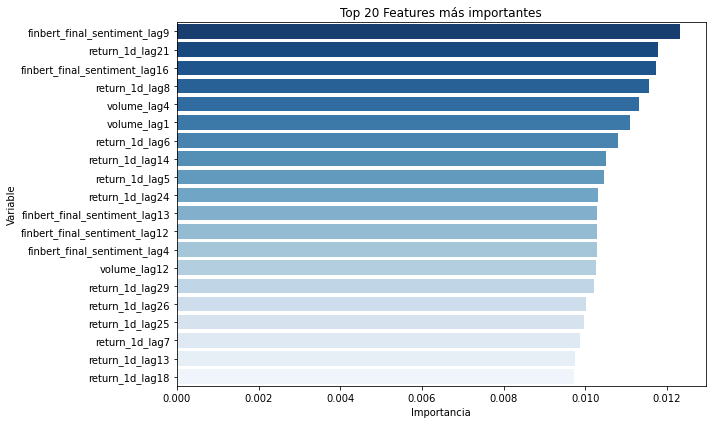

✅ Las 20 variables más importantes explican el 21.26% de la importancia total.


In [ ]:
# Obtener importancias
model = pipeline.named_steps["clf"]
importances = model.feature_importances_

# Asociar nombres de features
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names)

# Seleccionar top 20
top_20 = feat_imp.sort_values(ascending=False).head(20)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20.values, y=top_20.index, palette="Blues_r")
plt.title("Top 20 Features más importantes")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Calcular importancia total y acumulada del top 20
total_importance = feat_imp.sum()
top_20_importance = top_20.sum()
porcentaje_top_20 = (top_20_importance / total_importance) * 100

print(f"✅ Las 20 variables más importantes explican el {porcentaje_top_20:.2f}% de la importancia total.")

In [ ]:
# Seleccionar todas las columnas que son lags
lag_features = [col for col in df.columns if "lag" in col]
X = df[lag_features]
y = df["label_price"]

# Entrenar modelo base para sacar importancia
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# Obtener importancias y top 20 features
importances = pipeline.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=X.columns)
top_20_features = feat_imp.sort_values(ascending=False).head(20).index.tolist()

# Features más importantes
print("✅ TOP 20 FEATURES MÁS IMPORTANTES:")
for i, f in enumerate(top_20_features, 1):
    print(f"{i:02d}. {f}")

✅ TOP 20 FEATURES MÁS IMPORTANTES:
01. finbert_final_sentiment_lag9
02. return_1d_lag8
03. return_1d_lag29
04. return_1d_lag21
05. finbert_final_sentiment_lag30
06. finbert_final_sentiment_lag13
07. return_1d_lag2
08. return_1d_lag18
09. finbert_final_sentiment_lag29
10. finbert_final_sentiment_lag12
11. volume_lag10
12. volume_lag6
13. return_1d_lag22
14. finbert_final_sentiment_lag16
15. return_1d_lag7
16. return_1d_lag10
17. return_1d_lag25
18. return_1d_lag23
19. return_1d_lag6
20. finbert_final_sentiment_lag20


### Correlaciones

De estas features importantes del lag, se trata de buscar correlaciones altas para poder reducir efectos de multicolinealidad. Dicho esto,  en caso de que existan variables multicolineales, se buscará eliminar las variables que tengan menos importancia para el modelo.

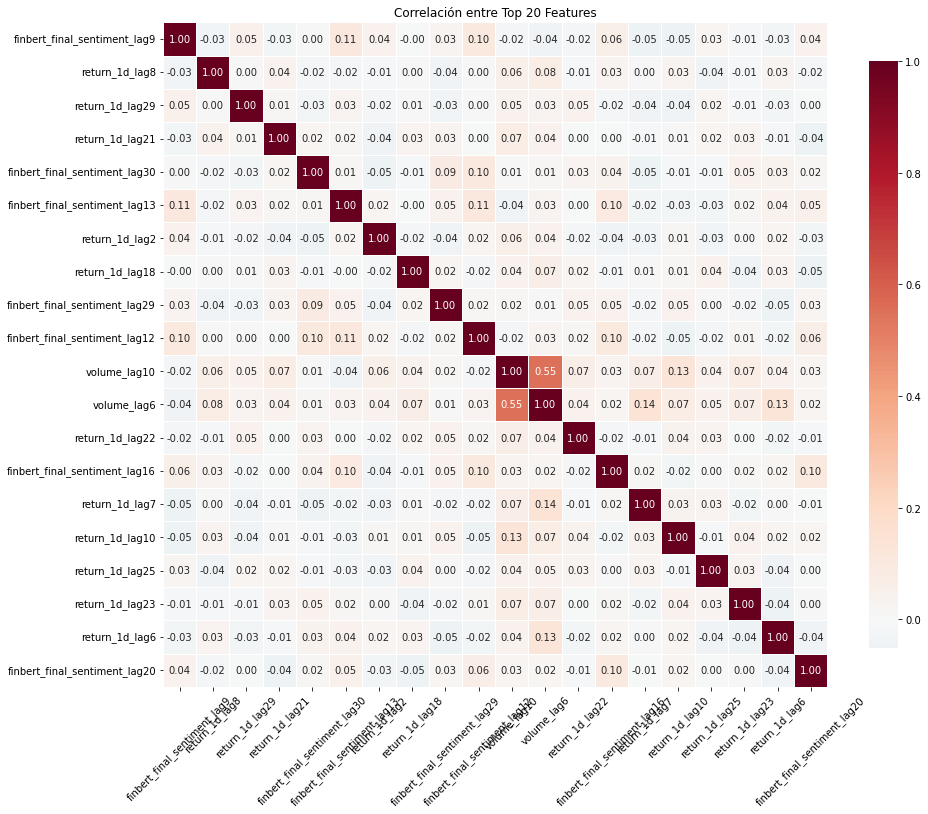

In [ ]:
# Dataset base (top 20 features ya seleccionadas)
X_top20 = df[top_20_features]

# Calcular matriz de correlación
correlation_matrix = X_top20.corr()

# Mostrar mapa de calor
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlación entre Top 20 Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Segunda ejecucion de modelos (XGBoost, Logistic Regression, Random Forest, SVM y KNN)
En una segunda etapa del analisis, se implementa una serie de modelos clasificadores utilizando exclusivamente las 20 variables más importantes identificadas previamente mediante análisis de Feature Importance. Para el entrenamiento, se emplea un pipeline que incluye normalización de las variables mediante StandardScaler, con el fin de mantener consistencia en la escala de los datos. El rendimiento del modelo se evalúa utilizando métricas de clasificación estándar, incluyendo precisión, recall, F1-score y AUC-ROC.

XGBoost se selecciona como primer modelo avanzado debido a su reconocida eficacia en tareas de clasificación con datos tabulares y potenciales relaciones no lineales. Su capacidad para manejar de forma nativa valores faltantes, junto con mecanismos de regularización y control de sobreajuste, lo convierten en una opción robusta y confiable. Además, su rendimiento consistente en competencias de ciencia de datos y aplicaciones prácticas lo posiciona como un punto de partida sólido antes de explorar otros modelos.

In [ ]:
# Se ejecuta el mismo pipeline previamente mencionado, pero con XGBoost

X_top = df[top_20_features]
y = df["label_price"]

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, stratify=y, random_state=42)

pipeline_top_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

pipeline_top_xgb.fit(X_train, y_train)

y_pred = pipeline_top_xgb.predict(X_test)
y_prob = pipeline_top_xgb.predict_proba(X_test)[:, 1]

print("🔍 XGBoost con TOP 20 features:")
print(classification_report(y_test, y_pred, target_names=["down", "up"]))
print("AUC-ROC:", round(roc_auc_score(y_test, y_prob), 3))

🔍 XGBoost con TOP 20 features:
              precision    recall  f1-score   support

        down       0.52      0.53      0.52       139
          up       0.58      0.57      0.58       157

    accuracy                           0.55       296
   macro avg       0.55      0.55      0.55       296
weighted avg       0.55      0.55      0.55       296

AUC-ROC: 0.545


Al mismo tiempo, se realiza la prueba con otros modelos tales como Logistic Regression, SVM y KNN. Asimismo, se vuelve a aplicar Random Forest para poder determinar si es que mejora o tiene mejores métricas que el XGBoost.

In [ ]:
# Se presentan los diferentes modelos a comparar
modelos = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(class_weight='balanced', probability=True, random_state=42),
    "KNN (Benchmark)": KNeighborsClassifier(n_neighbors=5)
}

# Entrenar y evaluar los otros modelos
for nombre, modelo in modelos.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", modelo)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    print(f"\n🔍 {nombre}")
    print(classification_report(y_test, y_pred, target_names=["down", "up"]))
    print("AUC-ROC:", round(roc_auc_score(y_test, y_prob), 3))


🔍 Logistic Regression
              precision    recall  f1-score   support

        down       0.49      0.55      0.52       139
          up       0.56      0.50      0.53       157

    accuracy                           0.52       296
   macro avg       0.52      0.52      0.52       296
weighted avg       0.53      0.52      0.52       296

AUC-ROC: 0.517

🔍 Random Forest
              precision    recall  f1-score   support

        down       0.56      0.41      0.47       139
          up       0.58      0.71      0.64       157

    accuracy                           0.57       296
   macro avg       0.57      0.56      0.56       296
weighted avg       0.57      0.57      0.56       296

AUC-ROC: 0.523

🔍 SVM (RBF)
              precision    recall  f1-score   support

        down       0.47      0.54      0.51       139
          up       0.54      0.47      0.50       157

    accuracy                           0.50       296
   macro avg       0.51      0.51      0.50  

## Tercer Modelo: XGBoost optimizado
Una vez determinado que el XGBoost es el modelo que mejores resultados trae, se realizó una optimización de algunos hiperparámetros y se incluyeron otras features para determinar si es que generaban valor o no al modelo.

Dado que los datos de sentimiento financiero suelen tener un alto nivel de ruido en contextos neutros o ambiguos, se aplica un umbral mínimo de sentimiento para filtrar únicamente aquellas observaciones donde el modelo de lenguaje (FinBERT) detecta una señal clara, ya sea positiva o negativa. Este enfoque permite focalizar el entrenamiento del modelo en instancias con mayor intensidad informativa, donde el sentimiento tiene más probabilidad de reflejar una expectativa real del mercado. Al reducir la influencia de datos con sentimiento débil o neutro los cuales pueden confundir al modelo, se mejora la relación señal/ruido y se incrementa la capacidad predictiva del sistema en los casos donde realmente importa.

In [ ]:
# Definir umbral de sentimiento fuerte (positivo o negativo) para reducir ruido del mercado.
umbral = 0.6

# Crear subset donde el sentimiento sea fuerte
df_filtrado = df[abs(df["finbert_final_sentiment"]) > umbral].copy()

print("📊 Filas con sentimiento fuerte:", len(df_filtrado))

# Usar solo esas filas para entrenar el modelo
X = df_filtrado[top_20_features + composite_macro_features]
y = df_filtrado["label_price"]

# Dividir y entrenar como antes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Optimización hiperparámetros a través de GridSearch
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [2, 3, 4],
    'clf__learning_rate': [0.01, 0.1],
    'clf__subsample': [0.8, 1.0]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluación del modelo con hiperparámetros optimizados
print("✅ Mejores parámetros:", grid.best_params_)
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

print("\n🔍 XGBoost Optimizado (sentimiento fuerte)")
print(classification_report(y_test, y_pred, target_names=["down", "up"]))
print("AUC-ROC:", round(roc_auc_score(y_test, y_prob), 3))

📊 Filas con sentimiento fuerte: 453
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Mejores parámetros: {'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 200, 'clf__subsample': 1.0}

🔍 XGBoost Optimizado (sentimiento fuerte)
              precision    recall  f1-score   support

        down       0.57      0.57      0.57        47
          up       0.55      0.55      0.55        44

    accuracy                           0.56        91
   macro avg       0.56      0.56      0.56        91
weighted avg       0.56      0.56      0.56        91

AUC-ROC: 0.64


## Cuarto Modelo: XGBoost con ensemble
Con el objetivo de combinar las fortalezas individuales de diferentes algoritmos de clasificación, se implementa un modelo de ensemble mediante voto ponderado (VotingClassifier). Este enfoque permite integrar de forma estratégica modelos complementarios como XGBoost, LightGBM y regresión logística, ajustando sus contribuciones relativas a través de pesos definidos manualmente. Al evaluar distintas combinaciones, se busca una sinergia que mejore la capacidad predictiva global del sistema, especialmente en contextos donde cada modelo capta patrones distintos en los datos. Esta técnica no solo mejora el rendimiento en métricas como el AUC-ROC, sino que también aporta mayor estabilidad y robustez frente a la variabilidad de las condiciones del mercado.

In [ ]:
# Dataset con ffill en caso hayan filas que no tengan datos y se necesiten para el logistic regression.
X = df_filtrado[top_20_features + composite_macro_features].fillna(method='ffill')
y = df_filtrado["label_price"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modelos individuales con imputación solo en lr
models = [
    ('xgb', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            learning_rate=0.1, max_depth=3, n_estimators=200,
            subsample=1.0, random_state=42, eval_metric='logloss', use_label_encoder=False
        ))
    ])),
    ('lgb', Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LGBMClassifier(
            class_weight='balanced', n_estimators=200, max_depth=3,
            learning_rate=0.1, random_state=42, verbose=-1
        ))
    ])),
    ('lr', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # <- Solo acá se imputan los NaNs
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            class_weight='balanced', max_iter=1000, random_state=42
        ))
    ]))
]

# Combinaciones de pesos para probar combinaciones de los modelos ensamblados.
weight_combinations = [
    ([0.4, 0.4, 0.2], "Balanceado con menos LR"),
    ([0.5, 0.3, 0.2], "Más peso a XGB"),
    ([0.3, 0.5, 0.2], "Más peso a LGB"),
    ([0.45, 0.45, 0.1], "Mínimo peso a LR"),
    ([0.8, 0.1, 0.1], "Dominancia XGB")
]

print("🎯 PROBANDO DIFERENTES PESOS DE ENSEMBLE:")
print("="*60)

best_auc = 0
best_weights = None
best_results = None

for weights, description in weight_combinations:
    print(f"\n📊 {description} - Pesos: {weights}")

    ensemble = VotingClassifier(
        estimators=models,
        voting='soft',
        weights=weights
    )

    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    y_proba = ensemble.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=["down", "up"]))

    if auc > best_auc:
        best_auc = auc
        best_weights = weights
        best_results = {
            'predictions': y_pred,
            'probabilities': y_proba,
            'description': description
        }

# Mostrar mejor resultado
print("\n" + "="*60)
print("🏆 MEJOR ENSEMBLE WEIGHTED:")
print("="*60)
print(f"Mejores pesos: {best_weights}")
print(f"Descripción: {best_results['description']}")
print(f"AUC-ROC: {best_auc:.3f}")
print(classification_report(y_test, best_results['predictions'], target_names=["down", "up"]))

# Entrenar el modelo final con los mejores pesos
print("\n🎯 MODELO FINAL OPTIMIZADO:")
print("="*40)

final_ensemble = VotingClassifier(
    estimators=models,
    voting='soft',
    weights=best_weights
)

final_ensemble.fit(X_train, y_train)
final_pred = final_ensemble.predict(X_test)
final_proba = final_ensemble.predict_proba(X_test)[:, 1]

print(f"AUC-ROC Final: {roc_auc_score(y_test, final_proba):.3f}")
print(classification_report(y_test, final_pred, target_names=["down", "up"]))

🎯 PROBANDO DIFERENTES PESOS DE ENSEMBLE:

📊 Balanceado con menos LR - Pesos: [0.4, 0.4, 0.2]
AUC-ROC: 0.644
              precision    recall  f1-score   support

        down       0.64      0.62      0.63        47
          up       0.61      0.64      0.62        44

    accuracy                           0.63        91
   macro avg       0.63      0.63      0.63        91
weighted avg       0.63      0.63      0.63        91


📊 Más peso a XGB - Pesos: [0.5, 0.3, 0.2]
AUC-ROC: 0.656
              precision    recall  f1-score   support

        down       0.66      0.66      0.66        47
          up       0.64      0.64      0.64        44

    accuracy                           0.65        91
   macro avg       0.65      0.65      0.65        91
weighted avg       0.65      0.65      0.65        91


📊 Más peso a LGB - Pesos: [0.3, 0.5, 0.2]
AUC-ROC: 0.632
              precision    recall  f1-score   support

        down       0.64      0.62      0.63        47
          up 